In [ ]:
#USE TensorFlow NEURAL NETWORK ON THE TITANIC DATASET ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [4]:
def create_model_data(filename):
    titanic=pd.read_csv(filename,header=0,index_col=False)
    
    titanic=titanic.join(pd.get_dummies(titanic['Pclass'],drop_first=False))
    titanic.rename(columns={1:'1st',2:'2nd',3:'3rd'},inplace=True)
    
    #Age_Known column with 1 value if age was originally known and 0 if unknown
    age_known=titanic['Age'].isnull().tolist()
    for index in range(0,len(age_known)):
        if age_known[index]==False:
            age_known[index]=0
        else:
            age_known[index]=1
    titanic['Age_Known']=age_known
    
    #Fill Age column with Avg age as per Sex and PassengerClass
    fem_avg_age_1=titanic['Age'][(titanic['Sex']=='female') & (titanic['Pclass']==1)].mean()
    fem_avg_age_2=titanic['Age'][(titanic['Sex']=='female') & (titanic['Pclass']==2)].mean()
    fem_avg_age_3=titanic['Age'][(titanic['Sex']=='female') & (titanic['Pclass']==3)].mean()
    male_avg_age_3=titanic['Age'][(titanic['Sex']=='male') & (titanic['Pclass']==3)].mean()
    male_avg_age_2=titanic['Age'][(titanic['Sex']=='male') & (titanic['Pclass']==2)].mean()
    male_avg_age_1=titanic['Age'][(titanic['Sex']=='male') & (titanic['Pclass']==1)].mean()
    for index in list(titanic.index):
        if titanic.loc[index,'Sex']=='female' and titanic['Age'].isnull()[index]==True:
            if titanic.loc[index,'Pclass']==1:
                titanic.loc[index,'Age']=fem_avg_age_1
            if titanic.loc[index,'Pclass']==2:
                titanic.loc[index,'Age']=fem_avg_age_2
            if titanic.loc[index,'Pclass']==3:
                titanic.loc[index,'Age']=fem_avg_age_3
        elif titanic.loc[index,'Sex']=='male' and titanic['Age'].isnull()[index]==True:
            if titanic.loc[index,'Pclass']==3:
                titanic.loc[index,'Age']=male_avg_age_3
            if titanic.loc[index,'Pclass']==2:
                titanic.loc[index,'Age']=male_avg_age_2
            if titanic.loc[index,'Pclass']==1:
                titanic.loc[index,'Age']=male_avg_age_1

    #Create a column with 1 value if Passenger's cabin is known and 0 is unknown
    cabin_known=[]
    for index in list(titanic.index):
        if titanic['Cabin'].isnull()[index]==True:
            cabin_known.append(0)
        else:
            cabin_known.append(1)
    titanic['cabin_known']=cabin_known
    titanic.drop('Cabin',axis=1,inplace=True)
    
    #Split the Sex column into the specific columns for Males and Females
    titanic=titanic.join(pd.get_dummies(titanic['Sex'],drop_first=True))

    #Use the SiblingSpoouse and ParentsChildren columns to find the people with any immediate family on-board and those alone.
    fam_on_board=[]
    alone=[]
    for index in list(titanic.index):
        fam_on_board.append(titanic.loc[index,'SibSp']+titanic.loc[index,'Parch'])
        if (titanic.loc[index,'SibSp']+titanic.loc[index,'Parch'])!=0:
            alone.append(0)
        else:
            alone.append(1)
    titanic['Fam_on_board']=fam_on_board
    titanic['Alone']=alone

    #Calculate the average cost per ticket for every individual to get a better idea of their wealth.
    cost_per_ticketholder=[]
    for index in list(titanic.index):
        if titanic.loc[index,'Fam_on_board']==0:
            cost_per_ticketholder.append(titanic.loc[index,'Fare'])
        else:
            cost_per_ticketholder.append(titanic.loc[index,'Fare']/titanic.loc[index,'Fam_on_board'])
    titanic['Cost_per_ticketholder']=cost_per_ticketholder

    #Get a separate column for each title in an individual's name to check for any correlation with their wealth and their chances of survival.
    title=[]
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4}
    for name in titanic['Name'].tolist():
        short=name.split(',')[1].split('.')[0].replace(" ",'')
        try:
            title.append(title_mapping[short])
        except:
            title.append(5)
    titanic['Title']=title
    
    #Create the column 'Child' with entry as 1 if the age is less than 16 and as 0 if greater than 16 years. 
    Child=[]
    for index in list(titanic.index):
        if int(titanic.loc[index,'Age'])<16:
            Child.append(1)
        else:
            Child.append(0)
    titanic['Child']=Child
    
    #Split the embarked column into the specific columns for the 3 locations from where the passengers boarded the Titanic
    titanic['Embarked'].fillna('S',axis=0,inplace=True)
    titanic=titanic.join(pd.get_dummies(titanic['Embarked'],drop_first=False))
    titanic.drop(['Embarked','Q'],axis=1,inplace=True)
    
    #Drop the extra columns
    titanic.drop(['Pclass','Name','Sex','Ticket'],axis=1,inplace=True)
    
    return titanic

In [5]:
train_df=create_model_data("train.csv")

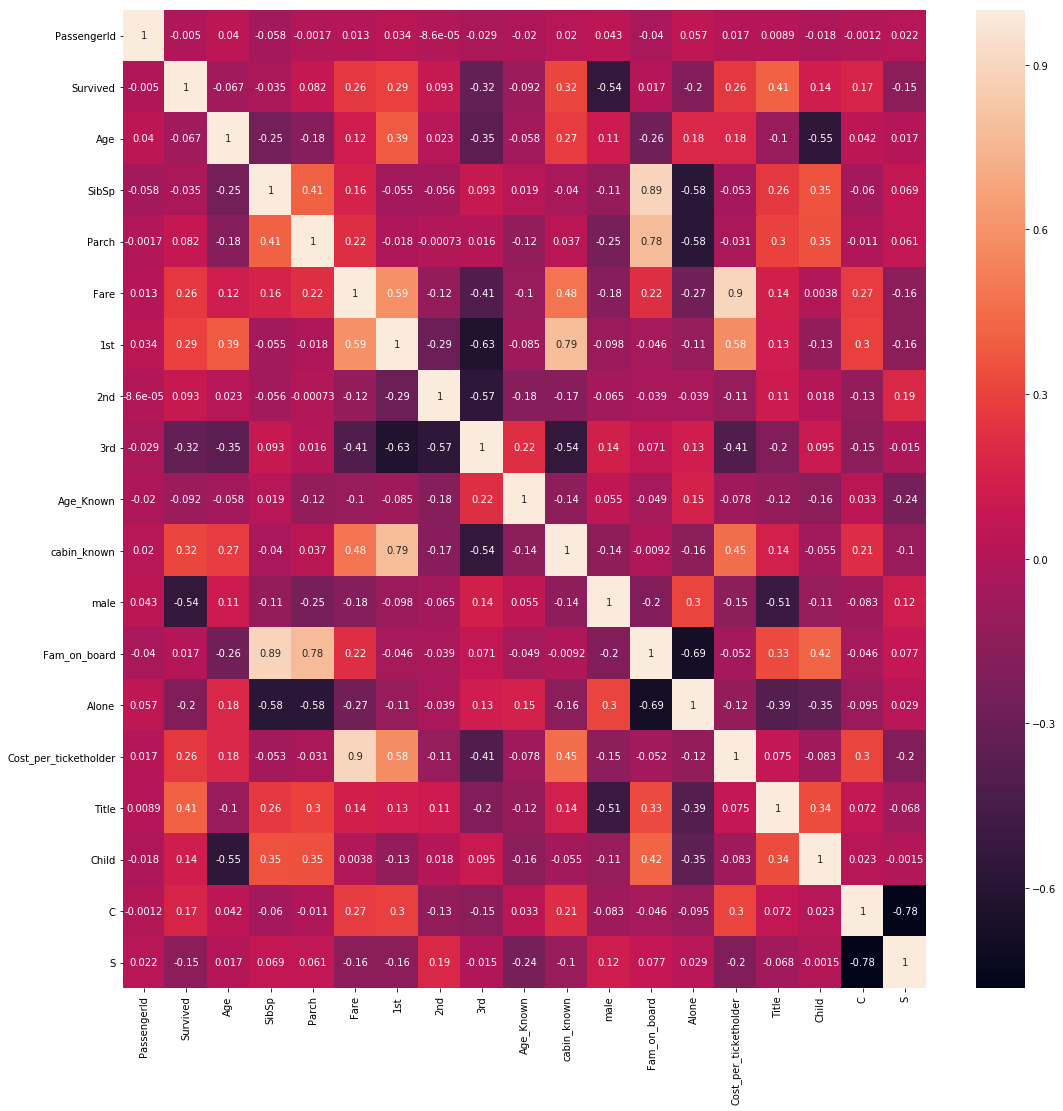

In [8]:
fig,ax=plt.subplots(figsize=(18,18))
sns.heatmap(train_df.corr(),annot=True)

In [10]:
##Function which is used to train a Neural Network to predict if a passenger dies or survives

def model_NN(X_train, X_test, y_train,hidden_units,batchsize):
    feat_col=[]
    for head in X_train.columns:
        feat_col.append(tf.feature_column.numeric_column(head))
    feat_col

    classifier=tf.estimator.DNNClassifier(hidden_units=[hidden_units],n_classes=20,feature_columns=feat_col)

    in_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=batchsize,shuffle=True,num_epochs=100)

    classifier.train(input_fn=in_func,steps=500)

    pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=batchsize,shuffle=False)

    predictions = list(classifier.predict(input_fn=pred_fn))

    final_preds=[]
    for pred in predictions:
        final_preds.append(pred['class_ids'][0])

    return final_preds

In [11]:
#Create Training and Testing Data

def create_test_train(train_df):
    X_train=train_df.drop('Survived',axis=1)
    y_train=train_df['Survived'].reset_index(drop=True)
    #X_test=test_df

    #from sklearn.preprocessing import StandardScaler
    #scaler=StandardScaler()
    #scaler.fit(X_train)
    #scaled_X_train=scaler.transform(X_train)
    #data_input=pd.DataFrame(data=scaled_X_train, columns=list(X_train.columns))
    #scaled_X_test=scaler.transform(X_test)

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=101)
    
    return X_train, X_test, y_train, y_test

In [12]:
##Iterate through multiple neural networks to find the ideal batch size and number of hidden layers

In [59]:
## finding ideal size of hidden layer ##

X_train, X_test, y_train, y_test=create_test_train(train_df)
y_test.reset_index(drop=True,inplace=True)
graph_df=pd.DataFrame()
not_type1=[]
not_type2=[]
avg_accuracy=[]
for hidden_units in range(1,26):
    not_type1_count=0
    not_type2_count=0
    correct_count=0
    final_preds=model_NN(X_train, X_test, y_train,int(hidden_units),batchsize=45)
    for index in range(0,len(final_preds)):
        if y_test[index]==1 and (y_test[index]==final_preds[index]):
            not_type2_count+=1
            correct_count+=1
        elif y_test[index]==0 and (y_test[index]==final_preds[index]):
            not_type1_count+=1
            correct_count+=1
    not_type1.append(not_type1_count/len([x for x in y_test if x==0]))
    not_type2.append(not_type2_count/len([x for x in y_test if x==1]))
    avg_accuracy.append(correct_count/len(final_preds))

graph_df['Hidden_Layer']=[x for x in range(1,26)]
graph_df['Average_Accuracy']=avg_accuracy
graph_df['True_Positives']=not_type1
graph_df['True_Negatives']=not_type2

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmpcwaeoir2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C7529AF198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into 

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmp1ii90mn0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C753AEE080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmp1ii

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmpnw340j0z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C754A98898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmpnw3

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmpdqn3_nha\model.ckpt.
INFO:tensorflow:loss = 523.2177, step = 1
INFO:tensorflow:global_step/sec: 232.542
INFO:tensorflow:loss = 36.400955, step = 101 (0.446 sec)
INFO:tensorflow:global_step/sec: 257.187
INFO:tensorflow:loss = 20.960556, step = 201 (0.373 sec)
INFO:tensorflow:global_step/sec: 261.324
INFO:tensorflow:loss = 25.268164, step = 301 (0.398 sec)
INFO:tensorflow:global_step/sec: 260.547
INFO:tensorflow:loss = 23.563955, step = 401 (0.384 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\hp1\AppData\Local\Temp\tmpdqn3_nha\model.ckpt.
INFO:tensorflow:Loss for final step: 15.443945.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
IN

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmpl6ipn9w3\model.ckpt.
INFO:tensorflow:loss = 294.96075, step = 1
INFO:tensorflow:global_step/sec: 231.829
INFO:tensorflow:loss = 24.61847, step = 101 (0.452 sec)
INFO:tensorflow:global_step/sec: 258.024
INFO:tensorflow:loss = 25.259607, step = 201 (0.383 sec)
INFO:tensorflow:global_step/sec: 259.521
INFO:tensorflow:loss = 23.716246, step = 301 (0.385 sec)
INFO:tensorflow:global_step/sec: 260.707
INFO:tensorflow:loss = 20.250154, step = 401 (0.381 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\hp1\AppData\Local\Temp\tmpl6ipn9w3\model.ckpt.
INFO:tensorflow:Loss for final step: 17.563026.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmpnr6z57oo\model.ckpt.
INFO:tensorflow:loss = 474.05975, step = 1
INFO:tensorflow:global_step/sec: 232.839
INFO:tensorflow:loss = 18.254217, step = 101 (0.429 sec)
INFO:tensorflow:global_step/sec: 257.46
INFO:tensorflow:loss = 19.465517, step = 201 (0.373 sec)
INFO:tensorflow:global_step/sec: 272.559
INFO:tensorflow:loss = 18.089478, step = 301 (0.383 sec)
INFO:tensorflow:global_step/sec: 260.929
INFO:tensorflow:loss = 27.08577, step = 401 (0.383 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\hp1\AppData\Local\Temp\tmpnr6z57oo\model.ckpt.
INFO:tensorflow:Loss for final step: 14.597246.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters fr

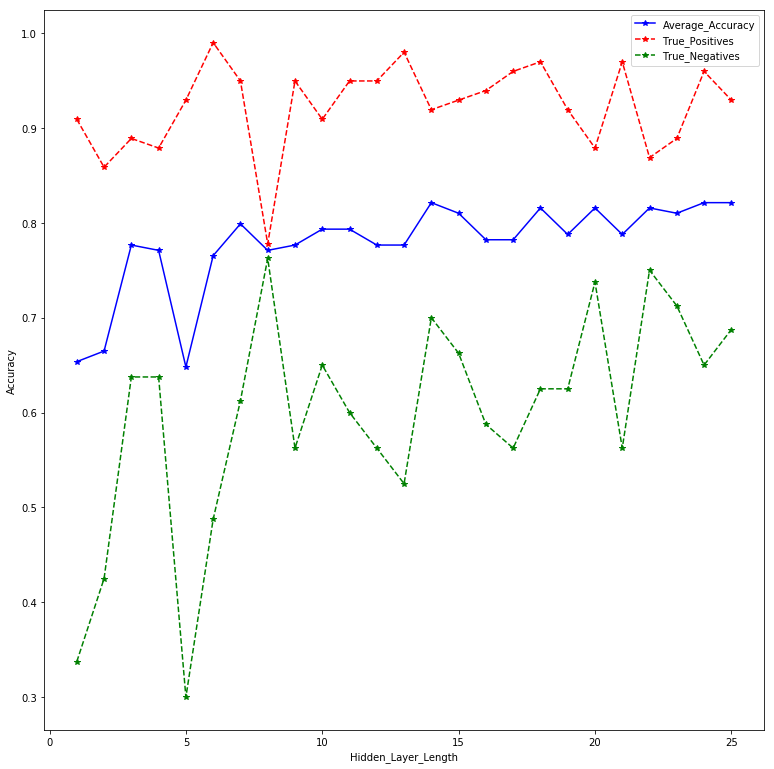

In [60]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_axes([0,0,1,1])
ax.plot(graph_df['Hidden_Layer'],graph_df['Average_Accuracy'],'b-',label='Average_Accuracy',marker='*')
ax.plot(graph_df['Hidden_Layer'],graph_df['True_Positives'],'r--',label='True_Positives',marker='*')
ax.plot(graph_df['Hidden_Layer'],graph_df['True_Negatives'],'g--',label='True_Negatives',marker='*')
ax.set_xlabel("Hidden_Layer_Length")
ax.set_ylabel("Accuracy")
ax.legend()

In [197]:
###### We get hidden layer size as 15 neurons ######

In [61]:
## finding ideal batch size##

X_train, X_test, y_train, y_test=create_test_train(train_df)
y_test.reset_index(drop=True,inplace=True)
graph_df=pd.DataFrame()
not_type1=[]
not_type2=[]
avg_accuracy=[]
for batchsize in range(5,101,5):
    not_type1_count=0
    not_type2_count=0
    correct_count=0
    final_preds=model_NN(X_train, X_test, y_train, 14,batchsize)
    for index in range(0,len(final_preds)):
        if y_test[index]==1 and (y_test[index]==final_preds[index]):
            not_type2_count+=1
            correct_count+=1
        elif y_test[index]==0 and (y_test[index]==final_preds[index]):
            not_type1_count+=1
            correct_count+=1
    not_type1.append(not_type1_count/len([x for x in y_test if x==0]))
    not_type2.append(not_type2_count/len([x for x in y_test if x==1]))
    avg_accuracy.append(correct_count/len(final_preds))

graph_df['Hidden_Layer']=[x for x in range(5,101,5)]
graph_df['Average_Accuracy']=avg_accuracy
graph_df['True_Positives']=not_type1
graph_df['True_Negatives']=not_type2

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmpcz8orl4f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C7529AFCF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into 

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmpf2ig_mrl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C74C6DBC88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmpf2i

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmp7cuhypam', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C7583A7828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmp7cu

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmpkngeul9l\model.ckpt.
INFO:tensorflow:loss = 1509.5311, step = 1
INFO:tensorflow:global_step/sec: 176.608
INFO:tensorflow:loss = 30.310993, step = 101 (0.566 sec)
INFO:tensorflow:global_step/sec: 227.897
INFO:tensorflow:loss = 19.717249, step = 201 (0.439 sec)
INFO:tensorflow:global_step/sec: 188.908
INFO:tensorflow:loss = 30.758554, step = 301 (0.529 sec)
INFO:tensorflow:global_step/sec: 185.447
INFO:tensorflow:loss = 23.900593, step = 401 (0.545 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\hp1\AppData\Local\Temp\tmpkngeul9l\model.ckpt.
INFO:tensorflow:Loss for final step: 29.0235.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INF

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\hp1\AppData\Local\Temp\tmppdd40ibj\model.ckpt.
INFO:tensorflow:loss = 644.691, step = 1
INFO:tensorflow:global_step/sec: 185.419
INFO:tensorflow:loss = 40.212097, step = 101 (0.539 sec)
INFO:tensorflow:global_step/sec: 211.874
INFO:tensorflow:loss = 38.319218, step = 201 (0.472 sec)
INFO:tensorflow:global_step/sec: 213.804
INFO:tensorflow:loss = 37.319405, step = 301 (0.468 sec)
INFO:tensorflow:global_step/sec: 209.768
INFO:tensorflow:loss = 41.120056, step = 401 (0.492 sec)
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\hp1\AppData\Local\Temp\tmppdd40ibj\model.ckpt.
INFO:tensorflow:Loss for final step: 39.866432.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.


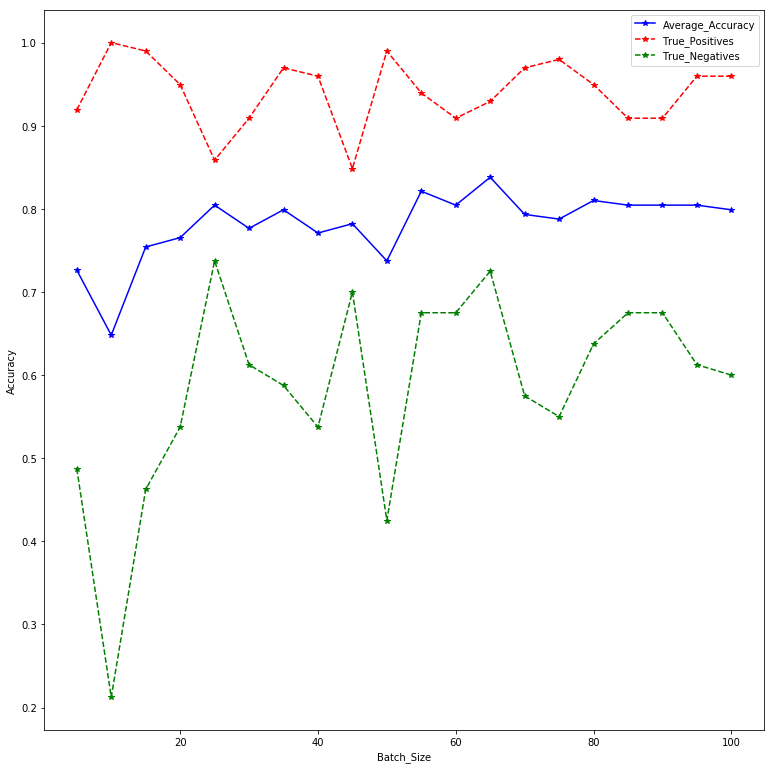

In [63]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_axes([0,0,1,1])
ax.plot(graph_df['Hidden_Layer'],graph_df['Average_Accuracy'],'b-',label='Average_Accuracy',marker='*')
ax.plot(graph_df['Hidden_Layer'],graph_df['True_Positives'],'r--',label='True_Positives',marker='*')
ax.plot(graph_df['Hidden_Layer'],graph_df['True_Negatives'],'g--',label='True_Negatives',marker='*')
ax.set_xlabel("Batch_Size")
ax.set_ylabel("Accuracy")
ax.legend()

In [215]:
###### We get batch_size as 25 ######

In [68]:
                ### Submission NEURAL NETWORK ###

                        # THE BEST MODEL YET #
            #with hidden layer of 15 and batch size 25

X_in=train_df.drop('Survived',axis=1)

X_train=X_in
X_test=test_df
y_train=train_df['Survived'].reset_index(drop=True)

feat_col=[]
for head in X_in.columns:
    feat_col.append(tf.feature_column.numeric_column(head))
feat_col

classifier=tf.estimator.DNNClassifier(hidden_units=[14],n_classes=20,feature_columns=feat_col)

in_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train, batch_size=25,shuffle=True,num_epochs=100)

classifier.train(input_fn=in_func,steps=500)

pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=25,shuffle=False)

predictions = list(classifier.predict(input_fn=pred_fn))

final_preds=[]
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

Submission=pd.DataFrame({ 'PassengerId': passenger_ID,'Survived': final_preds})
Submission.to_csv("Submission.csv", index=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\hp1\\AppData\\Local\\Temp\\tmpb9ifqqs6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000C758530FD0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into 